# The Impact of Transportation Methods on Air Quality in Big Cities

**Objective**: To analyze the relationship between transportation habits and air quality in urban areas to promote sustainable transportation options.

**Target Variable**: Air Quality (from metric_subcat_label)

**Relevant Independent Variables** (from metric_item_label):
- Public Transportation Use, 
- Drives Alone to Work, 
- Walking to Work, 
- Riding Bike to Work (from metric_item_label)


## 0. Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import folium
import branca
import ipywidgets as widgets
from IPython.display import display, update_display
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Legend
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

## 1. Motivation 
Air pollution is a significant environmental problem that affects the health and well-being of urban populations worldwide. Among the many sources of air pollution, transportation is a major contributor, particularly in urban areas. According to a case study conducted in the Greater Manchester region [1], road transport has significant impacts on urban air quality. Another recent study [2] explored the impact of public transportation on carbon emissions and found that it is an important factor to consider from the perspective of energy consumption.

Given the severity of the issue, it is essential to identify the cities with the least pollution and investigate the  find any patterns that contribute to its' decrease. In this story, we aim to analyze and compare the air quality of different US cities to find the city with the least air pollution. Additionally, we will investigate the transportation means used in these cities to identify any potential patterns that could be used as a model for other cities to follow. We aim to identify patterns and correlations between transportation means and air quality. By doing so, we hope to contribute to the efforts to reduce air pollution in urban areas and create healthier environments for people to live in.

In [2]:
# dataset: https://bigcitieshealthdata.org/
data = pd.read_csv('BigCitiesHealth.csv')
data.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4228\878469504.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BigCitiesHealth.csv')


,metric_item_label,metric_cat_label,metric_subcat_label,metric_item_label_subtitle,metric_cat_item_yaxis_label,metric_source_desc_label_fn,metric_source_desc_label_url_fn,geo_label_city,geo_label_state,geo_label_citystate,...,value_90_ci_low,value_90_ci_high,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,strata_race_label,strata_sex_label,strata_race_sex_label
0,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,San Antonio,TX,"San Antonio, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),White,Male,White Male
1,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Houston,TX,"Houston, TX",...,NaN,NaN,South,Poorest cities (20%+ poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),White,Male,White Male
2,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Fort Worth,TX,"Fort Worth, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),White,Male,White Male
3,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,El Paso,TX,"El Paso, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),White,Male,White Male
4,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Dallas,TX,"Dallas, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),White,Male,White Male


> **Brief Data Description**

The data we've chosen to work with is **The Big Cities Health Inventory (BCHI) data platform**.
> BCHI contains over 120 metrics across key public health categories, chosen for their impact on morbidity, mortality, and community well-being in the US. Metrics must meet substantive criteria relating to public health relevance, policy benchmarking, or demographic/socioeconomic disparity highlighting, as well as coverage and standardization criteria. The platform prioritizes publicly available, city-level data, with information from 2010 to 2021. The variables we use in our analysis are:

**Target Variable**: "Air Quality"
- Calculated using Air Quality Index (AQI) published by the Environmental Protection Agency. The 'Air Quality' value is calculated as $\frac{\text{No. of days with AQI} > 50}{\text{No. of days recorded}}$ [p. 15 in data description]

**Independent Variables**
- **1**. "Walking to Work" and **2**. "Riding Bike to Work": Calculated using the U.S. Census Bureau’s American Community Survey (ACS) 5-year estimates and is calculated from table B08137. The numerator is those who reported walking or riding a bicycle to work respectively. The denominator is all workers aged 16+ years who did not work at home. [p. 16 in data description]
- **3**. "Public Transportation Use" and **4**. "Drives Alone to Work": Calculated using the U.S. Census Bureau’s American Community Survey (ACS) 5-year estimates. The value is calculated as $\frac{\text{No. of citizens who reported using public transport}}{\text{No. of workers ages 16+ that who did not work from home}}$ and similarily for "Drives Alone to Work". [p. 16 in data description]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170725 entries, 0 to 170724
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   metric_item_label                170725 non-null  object 
 1   metric_cat_label                 170725 non-null  object 
 2   metric_subcat_label              170725 non-null  object 
 3   metric_item_label_subtitle       170725 non-null  object 
 4   metric_cat_item_yaxis_label      170725 non-null  object 
 5   metric_source_desc_label_fn      170725 non-null  object 
 6   metric_source_desc_label_url_fn  170725 non-null  object 
 7   geo_label_city                   170725 non-null  object 
 8   geo_label_state                  169516 non-null  object 
 9   geo_label_citystate              170725 non-null  object 
 10  geo_fips_code                    169516 non-null  float64
 11  value                            169957 non-null  float64
 12  da

In [4]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,value_90_ci_low,value_90_ci_high
count,1.695160e+05,169957.000000,170725.000000,110314.000000,110325.000000,0.0,0.0
mean,2.873797e+06,799.240387,2015.725102,446.619734,539.482406,NaN,NaN
std,1.697982e+06,4241.009061,3.385490,1747.515240,2039.646166,NaN,NaN
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320,NaN,NaN
25%,8.200000e+05,10.992568,2013.000000,9.400000,15.150000,NaN,NaN
50%,2.938000e+06,25.073544,2016.000000,20.757485,31.136362,NaN,NaN
75%,4.748000e+06,73.582871,2019.000000,91.258907,129.890367,NaN,NaN
max,5.553000e+06,99408.000000,2021.000000,27873.280170,29954.101410,NaN,NaN


We chose this particular dataset because looking for datasets from different cities that contain similar and complete data is a challenging task, but this dataset contained all the information we needed to do the analysis on air quality in cities. It has enough data to fins some interesting insights, this is, we have geographical data, we have time data, air quality, attributes such as means of transport that might impact on the air quality, among others. 

# 2. Basic stats

We only keep the attributes of interest for our analysis, the rest of the columns are dropped. 

In [5]:
columns_to_keep = ['geo_label_city', 'geo_label_citystate', 'value', 'date_label', 'metric_item_label', 'metric_subcat_label']
data = data[columns_to_keep]

data['date_label'] = pd.to_datetime(data['date_label'], format='%Y', errors='coerce')

print(data.isna().sum())

geo_label_city           0
geo_label_citystate      0
value                  768
date_label               0
metric_item_label        0
metric_subcat_label      0
dtype: int64


### 2.1. Handling Missing Values

In the columns relevant to our analysis, only $\frac{768}{170.725} \approx 0.4\%$ of **value** entries we're missing. Let's explore where these are missing.

In [6]:
missing_value = data[np.isnan(data['value'])==True]
missing_value['metric_item_label'].value_counts()

HIV/AIDS Prevalence             362
Police Killings                 300
Child Lead Levels 10+ mcg/dL     74
Population Density               12
Child Lead Testing               11
New Chlamydia Cases               3
Syphilis Prevalence               3
New Gonorrhea Cases               2
Child Lead Levels 5+ mcg/dL       1
Name: metric_item_label, dtype: int64

For now, we choose to drop these rows with missing values. If any of these labels turn out to show any importance in our later analysis, we will reconsider this decision.

In [7]:
# Drop the NaNs
data = data.dropna()
print(data.isna().sum())

geo_label_city         0
geo_label_citystate    0
value                  0
date_label             0
metric_item_label      0
metric_subcat_label    0
dtype: int64


### 2.2. Data Exploration

How many cities do we have?

In [8]:
print(f"Total Cities in the dataset: {len(data.geo_label_city.unique())}")

Total Cities in the dataset: 36


Now we want to get the geographical coordinates for each city and put them in two dataset columns.

In [9]:
cities = list(data.geo_label_citystate.unique())

def get_lat_lng(city):
    geolocator = Nominatim(user_agent="city_explorer")
    location = geolocator.geocode(city)
    
    if location is not None:
        print(f"Location found for {city}: ({location.latitude}, {location.longitude})")
        return location.latitude, location.longitude
    else:
        print(f"Location not found for: {city}")
        return None

city_data = {'City': cities}
df = pd.DataFrame(city_data)

df['Lat_Lng'] = df['City'].apply(get_lat_lng)

Location found for San Antonio, TX: (29.4246002, -98.4951405)
Location found for Houston, TX: (29.7589382, -95.3676974)
Location found for Fort Worth, TX: (32.753177, -97.3327459)
Location found for El Paso, TX: (31.7550511, -106.4882345)
Location found for Dallas, TX: (32.7762719, -96.7968559)
Location found for Austin, TX: (30.2711286, -97.7436995)
Location found for Memphis, TN: (35.1460249, -90.0517638)
Location found for Philadelphia, PA: (39.9527237, -75.1635262)
Location found for Portland, OR: (45.5202471, -122.674194)
Location found for Oklahoma City, OK: (35.4729886, -97.5170536)
Location found for Columbus, OH: (39.9622601, -83.0007065)
Location found for Cleveland, OH: (41.4996574, -81.6936772)
Location found for Charlotte, NC: (35.2272086, -80.8430827)
Location found for New York City, NY: (40.7127281, -74.0060152)
Location found for Kansas City, MO: (39.100105, -94.5781416)
Location found for Minneapolis, MN: (44.9772995, -93.2654692)
Location found for Detroit, MI: (42.3

In [10]:
df = df.dropna(subset=['Lat_Lng'])
df[['Latitude', 'Longitude']] = pd.DataFrame(df['Lat_Lng'].tolist(), index=df.index)


In [11]:
us_map = folium.Map(location=[37.7749, -100.4194], zoom_start=5, width='90%', height='90%')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=row['City'],
        fill=True,
        fill_opacity=0.7
    ).add_to(us_map)

us_map

### 2.3. Zooming in on air quality

Let's first take a look at the Air Quality in different cities (*Warmer means worse Air Quality*).

In [12]:
# extract rows with air 1 and air 2
air_df = data[data["metric_item_label"].isin(["Poor Air Quality", "Hazardous Air Quality"])]
# extract rows with car, bike, bus, and walk
other_df = data[data["metric_item_label"].isin(["Drives Alone to Work", "Riding Bike to Work", "Public Transportation Use", "Walking to Work"])]

# merge the two dataframes on the first column
result_df = pd.merge(air_df, other_df, on=["geo_label_citystate", "date_label"])

# rename the columns
result_df = result_df.drop(columns=['metric_subcat_label_x','metric_subcat_label_y', 'geo_label_city_x', 'geo_label_city_y'])
result_df = result_df.rename(columns={"metric_item_label_x": "Air_quality_based_on", "metric_item_label_y": "Transportation", "value_x":"air_value", "value_y":"transport_value"})
result_df = result_df.drop_duplicates()
# convert date column to datetime format
result_df["date_label"] = pd.to_datetime(result_df["date_label"])

# sort the dataframe based on date
result_df = result_df.sort_values("date_label")
result_df

,geo_label_citystate,air_value,date_label,Air_quality_based_on,transport_value,Transportation
2841,"Kansas City, MO",50.958904,2010-01-01,Poor Air Quality,80.002144,Drives Alone to Work
2930,"San Jose, CA",3.287671,2010-01-01,Hazardous Air Quality,1.581140,Walking to Work
2929,"San Jose, CA",29.041096,2010-01-01,Poor Air Quality,77.650173,Drives Alone to Work
2928,"San Jose, CA",29.041096,2010-01-01,Poor Air Quality,3.705474,Public Transportation Use
2927,"San Jose, CA",29.041096,2010-01-01,Poor Air Quality,0.901501,Riding Bike to Work
...,...,...,...,...,...,...
3344,"San Antonio, TX",42.857143,2021-01-01,Poor Air Quality,3.148786,Public Transportation Use
3345,"San Antonio, TX",42.857143,2021-01-01,Poor Air Quality,78.660530,Drives Alone to Work
3346,"San Antonio, TX",42.857143,2021-01-01,Poor Air Quality,77.757037,Drives Alone to Work
3348,"San Antonio, TX",42.857143,2021-01-01,Poor Air Quality,77.370824,Drives Alone to Work


In [13]:
air_quality_data = data[data['metric_subcat_label'] == 'Air Quality']
result_df['year'] = result_df['date_label'].dt.year

# Create a new DataFrame containing city, latitude, longitude, and air quality values
air_quality_df = df.merge(result_df, left_on='City', right_on='geo_label_citystate')
air_quality_df = air_quality_df[['City', 'Latitude', 'Longitude', 'Air_quality_based_on', 'air_value', 'transport_value', 'date_label', 'Transportation', 'year']]

# Create a new DataFrame containing only the values computed using 'Poor Air Quality'
air_quality_df_poor = air_quality_df[air_quality_df['Air_quality_based_on']=='Poor Air Quality']

# Create a new DataFrame containing only the values computed using 'Hazardous Air Quality'
air_quality_df_haz = air_quality_df[air_quality_df['Air_quality_based_on']=='Hazardous Air Quality']

We have to take into account that there are two ways in which the Air Quality is computed:
- For one it is used the 'Poor Air Quality' value, which means that the numerator is the number of days when AQI was >50. 
- For the other one it is used the 'Hazardous Air Quality', which means that the numerator is the number of days when AQI was >100. 

In both cases the denominator is number of days for which AQI is recorded. 

Hence, lets first see if their distributions follow the same pattern or not. 

#### 2.3.1. Air Quality computed using "Poor Air Quality"

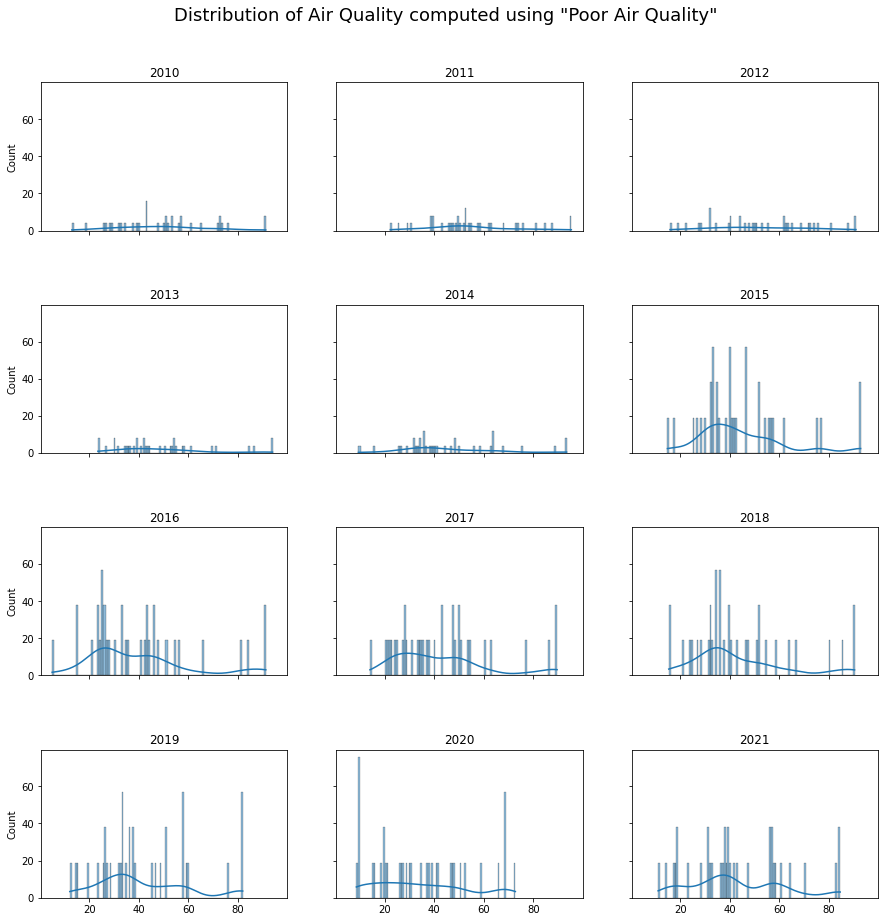

In [14]:
years = air_quality_df_poor['year'].unique()

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Distribution of Air Quality computed using "Poor Air Quality"', fontsize=18, y=0.95)

# loop through tickers and axes
for year, ax in zip(years, axs.ravel()):
    # filter df for ticker and plot on specified axes
    air_quality_df_poor_y = air_quality_df_poor[air_quality_df_poor['year']==year]
    sns.histplot(data=air_quality_df_poor_y, x='air_value', bins=100, kde=True, ax=ax)

    # chart formatting
    ax.set_title(str(year))
    ax.set_xlabel("")

plt.show()

From the previous plot we can anticipate that the output of the study can be interesting since it shows the air quality distribution and even though there are lots of cities with air quality 0, there are also with high air quality. Furthermore, by looking at the year distribution we see that from the ones with low quality there has been a decrease in the last years and it has been an increase in the high quality ones.  

In [15]:
# Create the folium map and add the HeatMap layer
heatmap_data_poor = air_quality_df_poor[['Latitude', 'Longitude', 'air_value']].values.tolist()
HeatMap(heatmap_data_poor).add_to(us_map)
us_map

Overall, it seems that the west coast cities are the one with poorest air quality over the years. However, we need to look into the yearly data to see if this pattern changes during the years. (See section 5) 

#### 2.3.2. Air Quality computed using "Hazardous Air Quality"

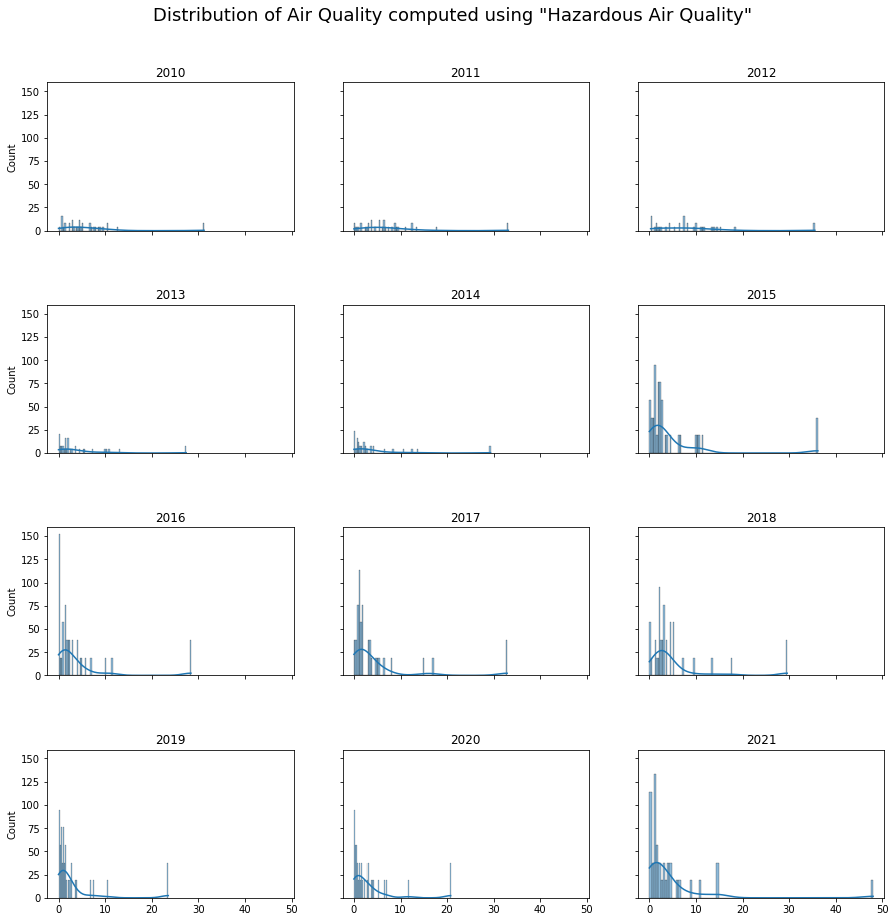

In [16]:
years = air_quality_df_haz['year'].unique()

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Distribution of Air Quality computed using "Hazardous Air Quality"', fontsize=18, y=0.95)

# loop through tickers and axes
for year, ax in zip(years, axs.ravel()):
    # filter df for ticker and plot on specified axes
    air_quality_df_haz_y = air_quality_df_haz[air_quality_df_haz['year']==year]
    sns.histplot(data=air_quality_df_haz_y, x='air_value', bins=100, kde=True, ax=ax)

    # chart formatting
    ax.set_title(str(year))
    ax.set_xlabel("")

plt.show()

In [17]:
# Create the folium map and add the HeatMap layer
heatmap_data_haz = air_quality_df_haz[['Latitude', 'Longitude', 'air_value']].values.tolist()
HeatMap(heatmap_data_haz).add_to(us_map)
us_map

FROM NOW ON WE'LL BE USING THE DATASET WHERE THE Air Quality IS computed using "Poor Air Quality", since both of them have the same distributions. 

#### 2.3.3. Time Series Plots 
<span style="color:red"> NOTE FROM LAURA: NOT SURE IF IT IS INSIGHTFUL THIS PART, IF IT IS, PLEASE COMMENT</span>

In [18]:
variables_of_interest = ['Public Transportation Use', 'Drives Alone to Work', 'Walking to Work', 'Riding Bike to Work']
filtered_data = air_quality_df_poor[air_quality_df_poor['Transportation'].isin(variables_of_interest)]
filtered_data.shape

(5355, 9)

In [19]:
filtered_data['Transportation'].unique()

array(['Walking to Work', 'Riding Bike to Work',
       'Public Transportation Use', 'Drives Alone to Work'], dtype=object)

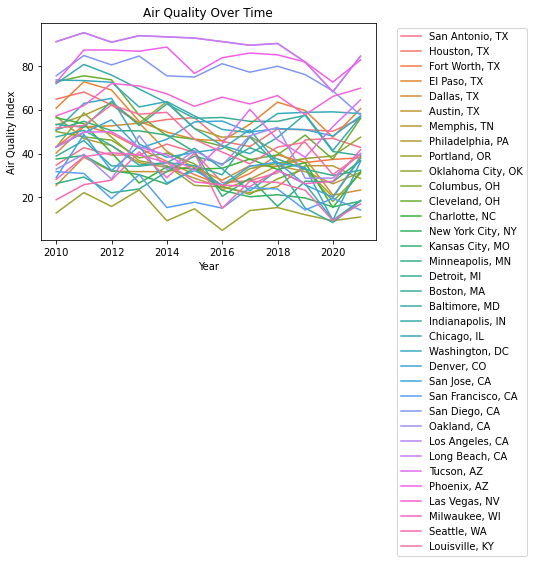

In [20]:
sns.lineplot(data=air_quality_df_poor, x='year', y='air_value', hue='City', ci=None)
plt.title('Air Quality Over Time')
plt.xlabel('Year')
plt.ylabel('Air Quality Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**To get a less busy time series plot, we split the data into groups based on their first Air Quality Value (2010).**

In [21]:
# Get the first period air quality data
first_period_data = air_quality_df_poor[air_quality_df_poor['year'] == air_quality_df_poor['year'].min()]

# Define air quality groups
air_quality_groups = {'<30': [], '30-40': [], '40-60': [], '60+': []}

# Assign cities to their air quality groups
for city in first_period_data['City'].unique():
    city_value = first_period_data[first_period_data['City'] == city]['air_value'].values[0]
    if city_value < 25:
        air_quality_groups['<30'].append(city)
    elif city_value < 40:
        air_quality_groups['30-40'].append(city)
    elif city_value < 60:
        air_quality_groups['40-60'].append(city)
    else:
        air_quality_groups['60+'].append(city)

# Print the air quality groups and their cities
for group, cities in air_quality_groups.items():
    print(f"{group}: {', '.join(cities)}")

<30: Portland, OR, Seattle, WA
30-40: San Antonio, TX, Austin, TX, New York City, NY, Minneapolis, MN, Boston, MA, San Jose, CA, San Francisco, CA, Oakland, CA, Milwaukee, WI
40-60: Fort Worth, TX, Dallas, TX, Memphis, TN, Philadelphia, PA, Oklahoma City, OK, Columbus, OH, Charlotte, NC, Kansas City, MO, Detroit, MI, Baltimore, MD, Washington, DC, Denver, CO, Tucson, AZ, Las Vegas, NV, Louisville, KY
60+: Houston, TX, El Paso, TX, Cleveland, OH, Indianapolis, IN, Chicago, IL, San Diego, CA, Los Angeles, CA, Long Beach, CA, Phoenix, AZ


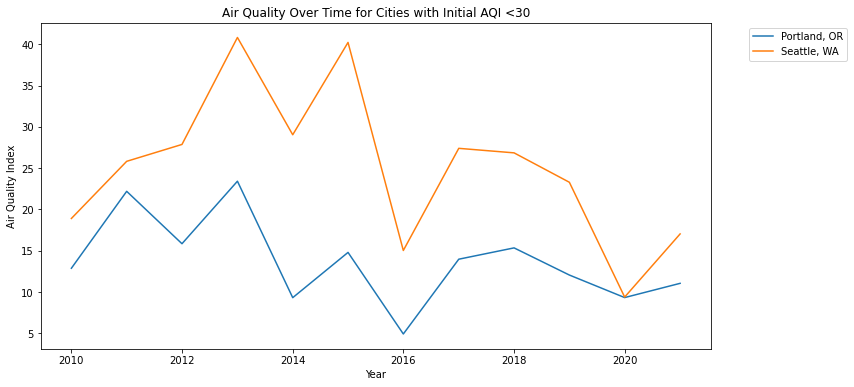

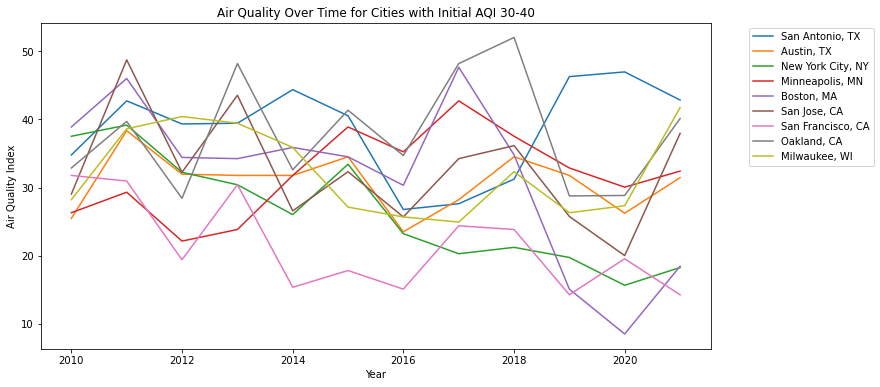

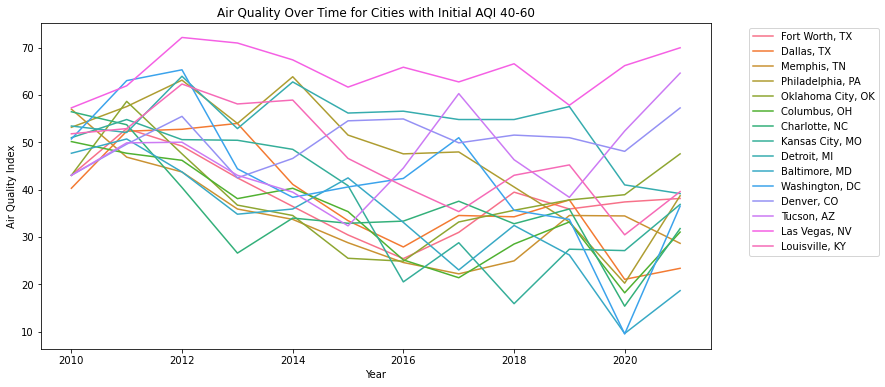

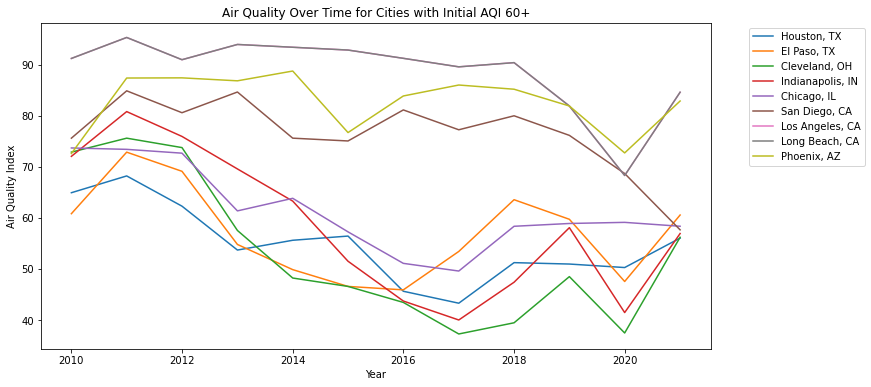

In [22]:
for group, cities in air_quality_groups.items():
    plt.figure(figsize=(12, 6))  # Set the figure size (width, height) in inches
    group_data = air_quality_df_poor[air_quality_df_poor['City'].isin(cities)]
    sns.lineplot(data=group_data, x='date_label', y='air_value', hue='City', ci=None)
    plt.title(f'Air Quality Over Time for Cities with Initial AQI {group}')
    plt.xlabel('Year')
    plt.ylabel('Air Quality Index')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

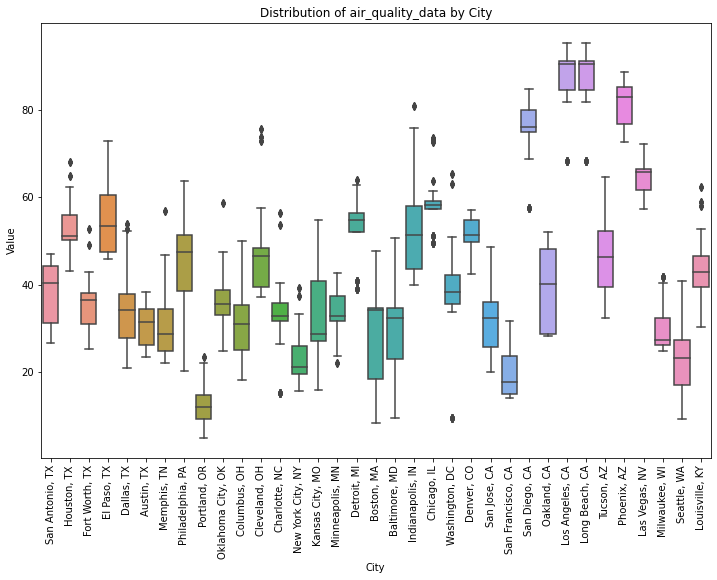

In [23]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='City', y='air_value', data=air_quality_df_poor)
plt.title('Distribution of air_quality_data by City')
plt.xlabel('City')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

EXAPLAIN VARIANCE

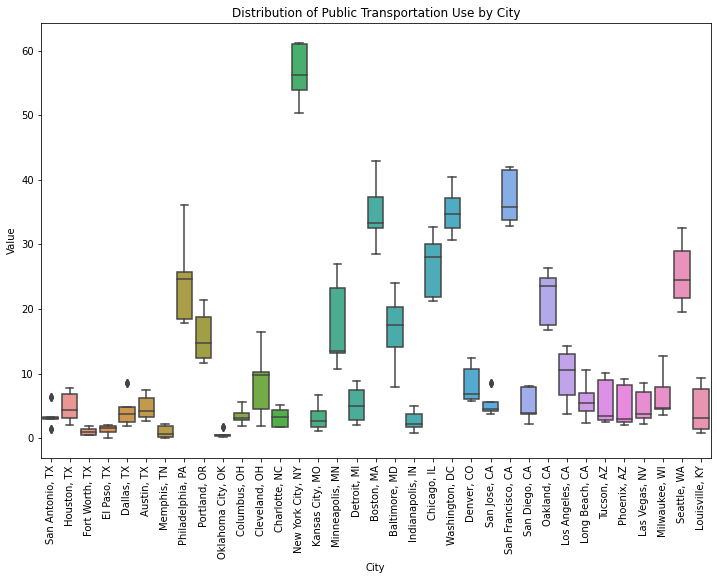

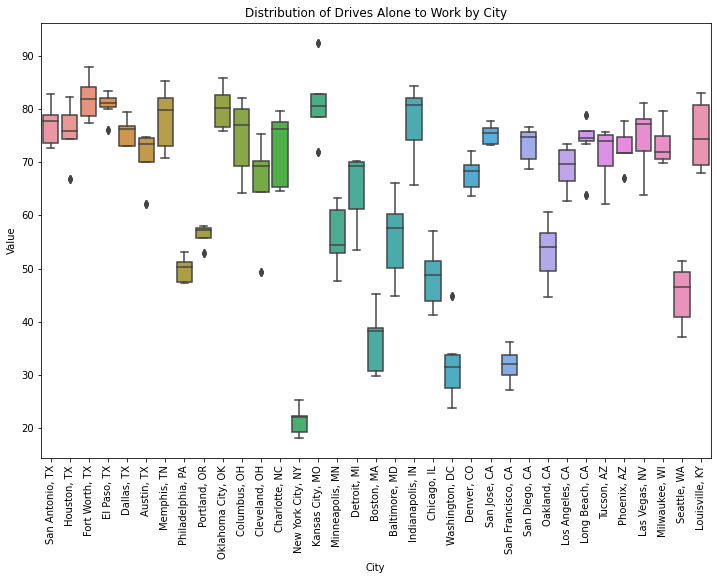

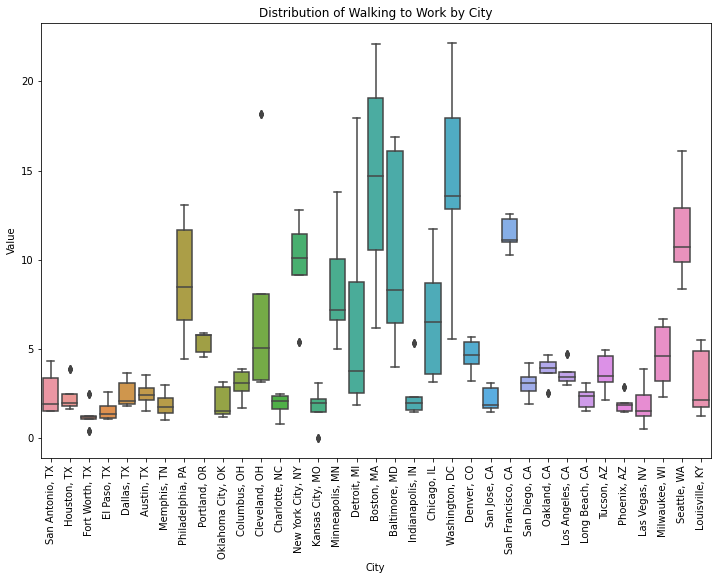

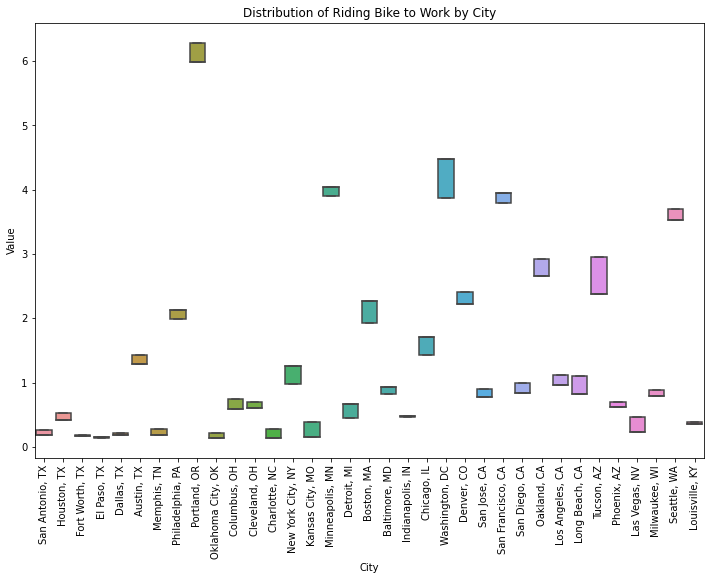

In [24]:
# Create a boxplot for each variable of interest, grouped by city
for variable in variables_of_interest:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='City', y='transport_value', data=filtered_data[filtered_data['Transportation'] == variable])
    plt.title(f'Distribution of {variable} by City')
    plt.xlabel('City')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.show()

#### 2.3.2 Correlation Matrix between air quality and transportation means

<span style="color:red"> NOTE FROM LAURA: IS THIS CORRECTLY CODED?</span>

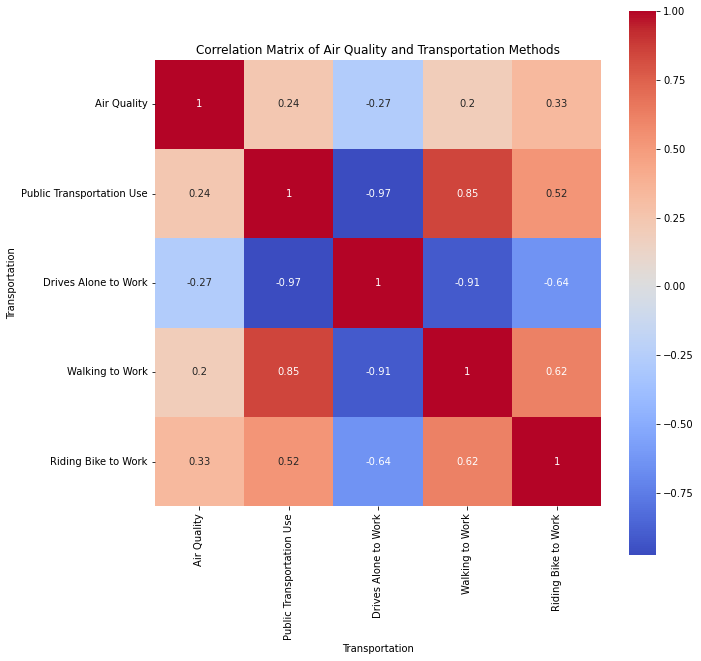

In [25]:
# Reshape the filtered dataset to have one row per city and year, with columns for each variable of interest
pivot_data = filtered_data.pivot_table(index=['City', 'date_label'], columns=['Transportation'], values='transport_value', aggfunc=np.mean).reset_index()

# Add the 'Air Quality' column to the pivot table
pivot_data['Air Quality'] = air_quality_df_poor['air_value']

# Calculate the correlation matrix for the variables of interest, including 'Air Quality'
variables_of_interest = ['Air Quality', 'Public Transportation Use', 'Drives Alone to Work', 'Walking to Work', 'Riding Bike to Work']
correlation_matrix = pivot_data[variables_of_interest].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Air Quality and Transportation Methods')
plt.show()

**There seems to be** some interesting correlations. 

> But before we lock in on our proposedly important independent features: **[Public Transportation Use, Drives Alone to Work, Walking to Work, Riding Bike to Work]**, we must try to identify other features that have relationships to our target feature **"Air Quality"**.

In [26]:
# Do feature selection with Air Quality as target

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

**What if we split the data into one dataset per. city?**

## 3. Data analysis
- Describe your data analysis and explain what you've learned about the dataset.
- If relevant, talk about your machine-learning.


>**Clustering**:

*See whether there are any similarities or groups* 

In [27]:
air_quality_df_poor

,City,Latitude,Longitude,Air_quality_based_on,air_value,transport_value,date_label,Transportation,year
0,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,1.924299,2010-01-01,Walking to Work,2010
1,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,0.263936,2010-01-01,Riding Bike to Work,2010
2,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,3.274290,2010-01-01,Public Transportation Use,2010
3,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,79.033772,2010-01-01,Drives Alone to Work,2010
8,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,42.739726,1.924299,2011-01-01,Walking to Work,2011
...,...,...,...,...,...,...,...,...,...
10703,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,73.426173,2021-01-01,Drives Alone to Work,2021
10704,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,74.255319,2021-01-01,Drives Alone to Work,2021
10705,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,69.461988,2021-01-01,Drives Alone to Work,2021
10706,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,68.004236,2021-01-01,Drives Alone to Work,2021


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4228\2826876844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_df_poor['Transport_int'] = air_quality_df_poor['Transportation'].map(value_map)


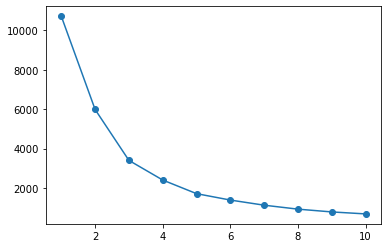

In [28]:
from sklearn.preprocessing import StandardScaler
unique_values = list(air_quality_df_poor['Transportation'].unique())
# create a dictionary mapping each unique value to a corresponding integer value
value_map = {value: i*10 for i, value in enumerate(unique_values)}
air_quality_df_poor['Transport_int'] = air_quality_df_poor['Transportation'].map(value_map)

scaler = StandardScaler()
my_data = air_quality_df_poor[['air_value', 'transport_value']]
X = scaler.fit_transform(my_data.values)
from sklearn.cluster import KMeans
wss = []
for i in range(1,11):
    cluster = KMeans(n_clusters=i,init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
    cluster.fit(X)
    wss.append(cluster.inertia_)
plt.plot(range(1,11),wss,marker ='o')


In [29]:
cluster_final = KMeans(n_clusters=3)
pred = cluster_final.fit_predict(X)
air_quality_df_poor['predict'] = pred
air_quality_df_poor

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4228\274665231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_df_poor['predict'] = pred


,City,Latitude,Longitude,Air_quality_based_on,air_value,transport_value,date_label,Transportation,year,Transport_int,predict
0,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,1.924299,2010-01-01,Walking to Work,2010,0,1
1,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,0.263936,2010-01-01,Riding Bike to Work,2010,10,1
2,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,3.274290,2010-01-01,Public Transportation Use,2010,20,1
3,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,34.794521,79.033772,2010-01-01,Drives Alone to Work,2010,30,0
8,"San Antonio, TX",29.424600,-98.495141,Poor Air Quality,42.739726,1.924299,2011-01-01,Walking to Work,2011,0,1
...,...,...,...,...,...,...,...,...,...,...,...
10703,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,73.426173,2021-01-01,Drives Alone to Work,2021,30,0
10704,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,74.255319,2021-01-01,Drives Alone to Work,2021,30,0
10705,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,69.461988,2021-01-01,Drives Alone to Work,2021,30,0
10706,"Louisville, KY",38.254238,-85.759407,Poor Air Quality,39.560440,68.004236,2021-01-01,Drives Alone to Work,2021,30,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


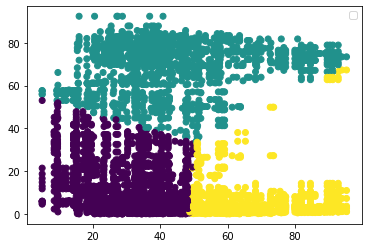

In [30]:
#plotting the results:
plt.scatter(air_quality_df_poor['air_value'] , air_quality_df_poor['transport_value'], c=pd.factorize(air_quality_df_poor['predict'])[0])
plt.legend()
plt.show()


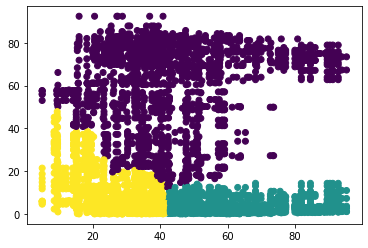

In [31]:
from sklearn.cluster import AgglomerativeClustering

# Define the clustering algorithm
agg = AgglomerativeClustering(n_clusters=3)

# Fit the clustering algorithm to the data
agg.fit(X)

# Extract the labels assigned to each data point
labels = agg.labels_
# plot the resulting clusters
plt.scatter(air_quality_df_poor['air_value'] , air_quality_df_poor['transport_value'], c=labels)
plt.show()

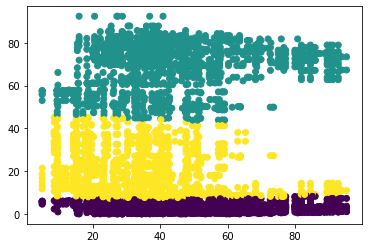

In [32]:
from sklearn.mixture import GaussianMixture

# Define the clustering algorithm
gmm = GaussianMixture(n_components=3)

# Fit the clustering algorithm to the data
gmm.fit(X)

# Extract the labels assigned to each data point
labels = gmm.predict(X)
# plot the resulting clusters
plt.scatter(air_quality_df_poor['air_value'] , air_quality_df_poor['transport_value'], c=labels)
plt.show()

>**Regression**: **Predict poor air quality based on transportation methods**

*Check the 2-5 cities who's air quality has gone up/down the most and do further analysis on these* 

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Specify the number of classes you want
num_classes = 5

# Use pd.cut() to create bins for the continuous variable
bins = pd.cut(air_quality_df_poor['air_value'], num_classes, labels=False)

# Assign the bin labels to the Y variable
air_quality_df_poor['air_label'] = bins

# Select relevant columns
X = air_quality_df_poor[['transport_value', 'Transportation']]
y = air_quality_df_poor['air_label']


# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['Transportation'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit a logistic regression model to the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict air quality values for the test data
y_pred = model.predict(X_test)

# Evaluate the performance of the model
score = model.score(X_test, y_test)
print('Accuracy:', score)
# Calculate the F1 score for each class and average them using 'macro' averaging
f1_macro = f1_score(y_test, y_pred, average='macro')

# Print the F1 score
print("F1 score (macro-averaged):", f1_macro)

Accuracy: 0.4057249533291848
F1 score (macro-averaged): 0.11544931385568835


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4228\127458021.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_df_poor['air_label'] = bins
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 4. Genre. Which genre of data story did you use?
- Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
- Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?


## 5. Final visualizations

By using a heat map to visualize changes in air quality over time, you can gain a deeper understanding of which areas of the United States have the highest levels of air pollution. The color gradient used in a heat map allows for easy overview of areas with the worst air quality. A heat map shows the patterns and trends in the data, with the color gradient indicating the level of air pollution. This method is helpful for identifying areas that need improvement in terms of air quality, and can also be used to track progress over time. 

From the analysis of the heat map, we were able to make a final decisions of which city has improved their overall air quality over time.

In [34]:
result_df = result_df.drop_duplicates()
result_df["date_label"] = pd.to_datetime(result_df["date_label"])
result_df = result_df.sort_values("date_label")

# Merge the air quality data and the city data
air_quality_df = df.merge(result_df, left_on='City', right_on='geo_label_citystate')
air_quality_df = air_quality_df[['City', 'Latitude', 'Longitude', 'Air_quality_based_on', 'air_value', 'date_label']]

# a list of years
years = np.sort(air_quality_df['date_label'].dt.year.unique())

def draw_map(year):
    title_html = f'''
        
        <h3 align="center" style="font-size:20px"><b>Heatmap of Air Quality in US in {year}</b></h3>
    '''
    us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4, height=500)
    us_map.get_root().html.add_child(folium.Element(title_html))
    heatmap_data = air_quality_df[(air_quality_df['date_label'].dt.year == year)][['Latitude', 'Longitude', 'air_value']].values.tolist()
    hm = HeatMap(heatmap_data, name='Air Quality', blur=10,)
    hm.add_to(us_map)
    colormap = branca.colormap.LinearColormap(['green', 'yellow', 'red'], vmin=0, vmax=500)
    colormap.caption = 'Air Quality Scale'
    us_map.add_child(colormap)
    folium.LayerControl().add_to(us_map)
    return us_map

year_widget = widgets.Dropdown(options=years, value=years[0], description='Select year:')
display(year_widget)

# draw_map function to initialize the heatmap
draw_map(year_widget.value)

# function to update the heatmap when the year is changed
def on_year_change(change):
    new_year = year_widget.value
    us_map = draw_map(new_year)
    update_display(us_map, display_id="map")

year_widget.observe(on_year_change, names='value')

us_map = draw_map(year_widget.value)
display(us_map, display_id="map")

Dropdown(description='Select year:', options=(2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020…

<DisplayHandle display_id=map>

After conducting a thorough analysis of air quality data, it was found that XXX City exhibited the most significant change in air quality. In order to explore this change, a visualization was created in the form of a stacked bar chart for each year, displaying the contribution of different transport means to the city's overall air quality, as well as a line depicting changes in air quality over time.

The stacked bar chart provides a visual representation of the relative contribution of different means of transportation to air pollution in XXX City over time. This allows for a better understanding of which types of transport are most responsible for contributing to air pollution.

In addition, the line allows for a better understanding of changes in air quality over time. By plotting air quality levels on the y-axis against time on the x-axis, it becomes clear how air quality has changed in XXX City over the given period, and whether any particular years exhibited significant improvements or declines. This information can be used to identify potential causes of changes in air quality, and to develop targeted interventions aimed at improving air quality in the city.

In [39]:
# narrow down the data to only include New York City and transport metrics
nyc_transport_data = air_quality_df_poor[(air_quality_df_poor['City'] == 'New York City, NY')]

nyc_transport_grouped = nyc_transport_data.groupby(['year', 'Transportation']).sum()['transport_value'].reset_index()
colors = Spectral4[:len(nyc_transport_grouped['Transportation'].unique())]

# create the figure
p = figure(
    x_range=nyc_transport_data['year'].astype(str).unique(), 
    plot_height=500, 
    plot_width=900,
    title="Transportation Changes in New York City over Time",
    toolbar_location=None, 
    tools="")

stackers = nyc_transport_grouped['Transportation'].unique().tolist()

# create the stacked bars 
p.vbar_stack(
    stackers=stackers,
    x='year', 
    source=ColumnDataSource(nyc_transport_grouped), 
    legend_label=stackers,
    line_color='white', 
    color= colors,
)

# set the legend properties
p.add_layout(Legend(), 'right')
p.legend.label_text_font_size = "10pt"

# set axis labels
p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Transport Value"

# Show the plot
output_notebook()
show(p)

Loading BokehJS ...

## 6. Discussion. Think critically about your creation
- What went well?,
- What is still missing? What could be improved?, Why?


## 7. Contributions. Who did what?
You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
It is not OK simply to write "All group members contributed equally".


## 8. References:

[1] Longhurst, J. W. S., D. Rayfield, and D. E. Conlan. 1994. "The Impacts Of Road Transport On Urban Air Quality-A Case Study Of The Greater Manchester Region." WIT Transactions on Ecology and the Environment 3.

[2] Jing, Qin-Lei, Han-Zhen Liu, Wei-Qing Yu, and Xu He. 2022. "The Impact of Public Transportation on Carbon Emissions—From the Perspective of Energy Consumption" Sustainability 14, no. 10: 6248. https://doi.org/10.3390/su14106248 